# Computational Linear Algebra
### MNIST Dataset - Comparing different dimensionality reducion methods
#### PCA / MDS / T-SNE
Juan Camilo Sarmiento - Equinox - Plan Semilla - Data Science

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Load the MNIST dataset (the small one),(with the original which has 60000 samples is too large to process in MDS):

In [2]:
from sklearn import datasets
mnist=datasets.load_digits()
mnist.data.shape,mnist.target.shape

((1797, 64), (1797,))

Define pca functions:

In [26]:
def standardize_matrix(X):
    num = X - np.mean(X,axis=0)
    den = np.std(X,axis=0)
    res = np.divide(num,den,out=np.zeros_like(num),where=den!=0)
    return res

def cov_matrix(standard_data):
    return np.matmul(standard_data.T,standard_data)/standard_data.shape[0]

def get_components_eig(matrix,components):
    evals,evecs=np.linalg.eig(matrix)   # get eigen values and vectors
    idx=evals.argsort()[::-1]    #get index of descending sorted eigenvalues
    evals=evals[idx]   #sort eigenvalues
    evecs=evecs[:,idx]  #sort eigenvectors
    evecs_pca=evecs[:,:components]  #get first n comonents
    return evecs_pca

def get_points_pca(standard_data,evecs_pca):
    evecs_pca=evecs_pca.T
    points=np.matmul(evecs_pca,standard_data.T).T
    return points

def visualize_w_pca(points,labels):
    sns.scatterplot(x=points[:points.shape[0],0],y=points[:points.shape[0],1],hue=labels[:points.shape[0]],palette='deep')
    plt.xlabel("component 1")
    plt.ylabel("component 2")
    plt.title(f"Visualization of MNIST using the first {points.shape[1]} components PCA")
    plt.show()

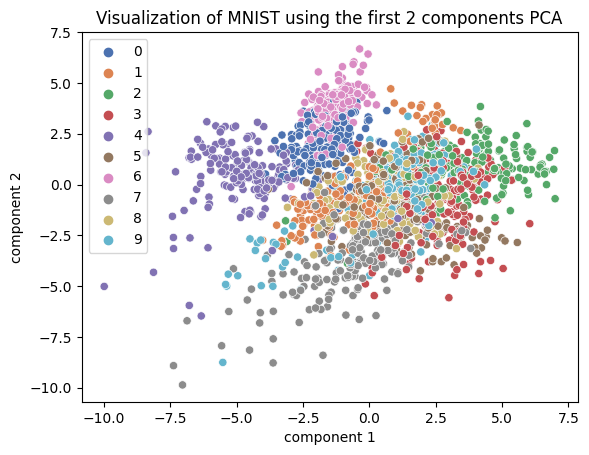

In [30]:
std_mnist=standardize_matrix(mnist.data)
points_pca=get_points_pca(std_mnist,get_components_eig(cov_matrix(std_mnist),2))
visualize_w_pca(points_pca,mnist.target)

Define MDS functions:

Note: Read Pyrcz, Michael J. (2021). PythonNumericalDemos: Educational Data Science Demonstrations Repository (1.0.0). Zenodo. https://doi.org/10.5281/zenodo.5564991

In [5]:
def get_distance_matrix(standard_data):
    x2=np.sum(np.power(standard_data,2),axis=1)[:,np.newaxis]   #y2 is the same, its not between two matrices but the same
    # print(x2[:5])
    xy=standard_data @ standard_data.T
    # print(xy[:5,:5])
    dists2 = 2*x2 - 2*xy
    dists=np.sqrt(dists2)
    print(dists[:5,:5])

get_distance_matrix(np.linspace(1,50).reshape(10,5))
# get_distance_matrix(std_mnist)

[[ 0.                 nan         nan         nan         nan]
 [20.          0.                 nan         nan         nan]
 [36.05551275 25.49509757  0.                 nan         nan]
 [51.96152423 42.42640687 30.          0.                 nan]
 [67.82329983 58.73670062 47.95831523 33.91164992  0.        ]]


C:\Users\jsarmiento\AppData\Local\Temp\ipykernel_12960\502467350.py:7: RuntimeWarning: invalid value encountered in sqrt
  dists=np.sqrt(dists2)


As manual computation by using matrix multiplication is not reliable, and iterative manual methods are too complex and take a long time to compute, distance matrix method from scipy is used:

In [6]:
from scipy.spatial import distance_matrix
distance_matrix(std_mnist,std_mnist)[:5,:5]

array([[ 0.        , 10.98806596, 10.52532875,  9.42050939,  9.47604884],
       [10.98806596,  0.        ,  8.25397221,  8.51556651,  9.07358018],
       [10.52532875,  8.25397221,  0.        , 10.56297658,  9.84512754],
       [ 9.42050939,  8.51556651, 10.56297658,  0.        ,  9.84204258],
       [ 9.47604884,  9.07358018,  9.84512754,  9.84204258,  0.        ]])

In [7]:
distance_matrix(std_mnist,std_mnist).shape

(1797, 1797)

In [8]:
def get_m(dist_matrix):
    return np.ones(shape=(len(dist_matrix),1))*(1/len(dist_matrix))  #every variable has the same weight

def get_centering_matrix(m):
    return np.identity(n=len(m)) - np.full(shape=(len(m),len(m)),fill_value=m)

def calculate_cross_product_matrix(C,D):
    return -0.5*np.matmul(C,np.matmul(D,np.transpose(C)))

def decompose_s(S):
    evals,evecs=np.linalg.eig(S)
    Lambda = np.where(evals<=0,0,evals)
    return Lambda,evecs

def get_projections_mds(m,Lambda,evecs):
    scores = np.matmul(np.sqrt(np.linalg.inv(np.diag(m[:,0]))),np.matmul(evecs,np.sqrt(np.diag(Lambda))))
    x_proj = scores[:,0]
    y_proj = scores[:,1]
    return x_proj,y_proj

In [9]:
dist_matrix=distance_matrix(std_mnist,std_mnist)
m=get_m(dist_matrix)
centering=get_centering_matrix(m)
S=calculate_cross_product_matrix(centering,dist_matrix)
evals_MDS,evecs_MDS=decompose_s(S)
mds_dim1,mds_dim2=get_projections_mds(m,evals_MDS,evecs_MDS)

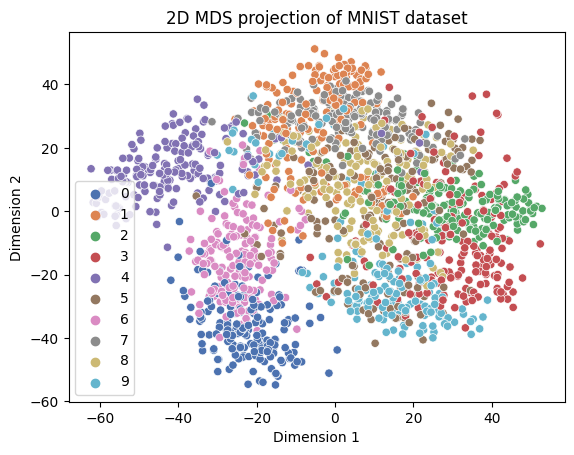

In [10]:
def visualize_w_mds(x,y,labels):
    sns.scatterplot(x=x,y=y,hue=labels,palette='deep')
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.title(f"2D MDS projection of MNIST dataset")
    plt.show()

visualize_w_mds(mds_dim1,mds_dim2,labels=mnist.target)

##### t-SNE
To understand: 
- van der Maaten,L. , Hinton, G: https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf
- Adam Orucu: https://towardsdatascience.com/understanding-t-sne-by-implementing-2baf3a987ab3

Define t-NSE functions:

In [17]:
#functions from Adam Orucu

def pairwise_distances(X):
    return np.sum((X[None, :] - X[:, None])**2, 2)

def p_conditional(dists, sigmas):
    e = np.exp(-dists / (2 * np.square(sigmas.reshape((-1,1)))))
    np.fill_diagonal(e, 0.)
    e += 1e-8
    return e / e.sum(axis=1).reshape([-1,1])

def perp(condi_matr):
    ent = -np.sum(condi_matr * np.log2(condi_matr), 1)
    return 2 ** ent

def find_sigmas(dists, perplexity):
    found_sigmas = np.zeros(dists.shape[0])
    for i in range(dists.shape[0]):
        func = lambda sig: perp(p_conditional(dists[i:i+1, :], np.array([sig])))
        found_sigmas[i] = search(func, perplexity)
    return found_sigmas

def search(func, goal, tol=1e-10, max_iters=1000, lowb=1e-20, uppb=10000):
    import warnings
    for _ in range(max_iters):
        guess = (uppb + lowb) / 2.
        val = func(guess)

        if val > goal:
            uppb = guess
        else:
            lowb = guess

        if np.abs(val - goal) <= tol:
            return guess

    warnings.warn(f"\nSearch couldn't find goal, returning {guess} with value {val}")
    return guess

def q_joint(y):
    dists = pairwise_distances(y)
    nom = 1 / (1 + dists)
    np.fill_diagonal(nom, 0.)
    return nom / np.sum(np.sum(nom))

def gradient(P, Q, y):
    (n, no_dims) = y.shape
    pq_diff = P - Q
    y_diff = np.expand_dims(y,1) - np.expand_dims(y,0) 

    dists = pairwise_distances(y)
    aux = 1 / (1 + dists)
    return 4 * (np.expand_dims(pq_diff, 2) * y_diff * np.expand_dims(aux,2)).sum(1)

def m(t):
    return 0.5 if t < 250 else 0.8

def p_joint(X, perp):
    N = X.shape[0]
    dists = pairwise_distances(X)
    sigmas = find_sigmas(dists, perp)
    p_cond = p_conditional(dists, sigmas)
    return (p_cond + p_cond.T) / (2. * N)

def tsne(X, ydim=2, T=1000, l=500, perp=30,seed=None):     #X=data,ydim=resulting dimensions, t=iterations,l=rate,perp=perplexity between 5 and 50
    N = X.shape[0]
    P = p_joint(X, perp)

    Y = []
    if seed is not None:   #add seed for replicability
        np.random.seed(seed)   
    y = np.random.normal(loc=0.0, scale=1e-4, size=(N,ydim))
    Y.append(y); Y.append(y)

    for t in range(T):                                    
        Q = q_joint(Y[-1])
        grad = gradient(P, Q, Y[-1])
        y = Y[-1] - l*grad + m(t)*(Y[-1] - Y[-2])
        Y.append(y)
        if t % 10 == 0:
            Q = np.maximum(Q, 1e-12)
    return y

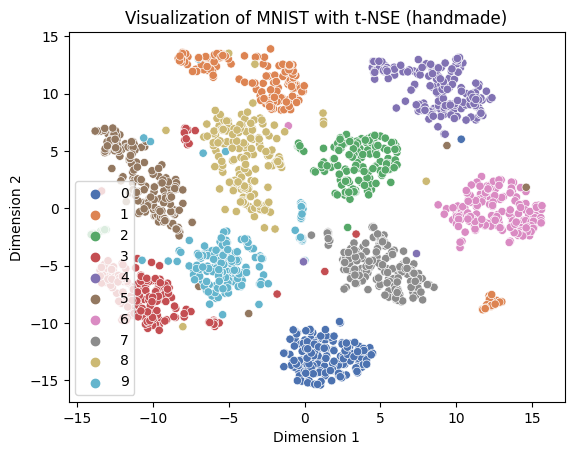

In [44]:
res_tsne=tsne(mnist.data,T=1000,l=50,perp=30,seed=0)   #values passed replicate defaults of sklearn
sns.scatterplot(x=res_tnse[:,0],y=res_tnse[:,1],hue=mnist.target,palette='deep')
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("Visualization of MNIST with t-NSE (handmade)")
plt.show()

Comparing all 3:

In [21]:
def pca_sklearn(components,data):
    from sklearn import decomposition
    std_data=standardize_matrix(data)
    pca=decomposition.PCA(n_components=components)
    pca_data=pca.fit_transform(std_data)
    return pca_data

def mds_sklearn(components,data):
    from sklearn.manifold import MDS
    mds=MDS(n_components=components)
    mds_data=mds.fit_transform(data)
    return mds_data

def tSNE_sklearn(components,data,rand_state):
    from sklearn.manifold import TSNE
    std_data=standardize_matrix(data)
    tsne_sk=TSNE(n_components=components,random_state=rand_state)
    tsne_data=tsne_sk.fit_transform(std_data)
    return tsne_data

In [32]:
pca2=pca_sklearn(components=2,data=mnist.data)
mds2=mds_sklearn(components=2,data=mnist.data)
tsne2=tSNE_sklearn(components=2,data=mnist.data,rand_state=0)
pca2.shape,mds2.shape,tsne2.shape

c:\Users\jsarmiento\Documents\Semilla\DATA_SCIENCE\venv_data_science\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


((1797, 2), (1797, 2), (1797, 2))

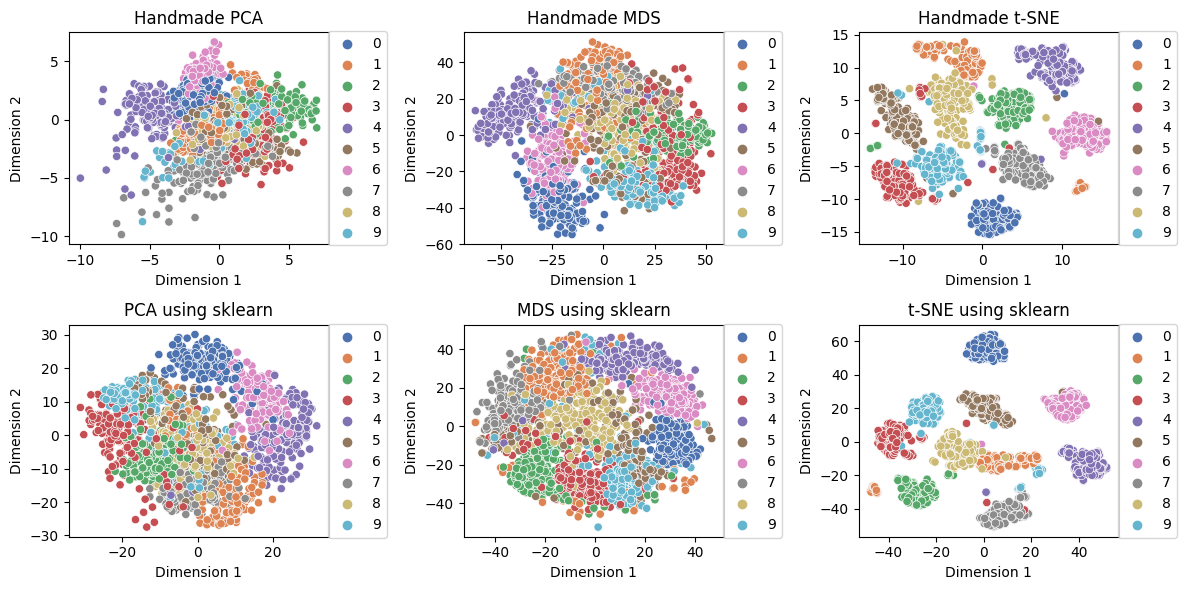

In [53]:
def plot_compare(man_pcax,man_pcay,man_mdsx,man_mdsy,man_tsnex,man_tsney,sk_pcax,sk_pcay,sk_mdsx,sk_mdsy,sk_tsnex,sk_tsney,labels):
    fig,axs=plt.subplots(2,3,figsize=(12,6),tight_layout=True)
    sns.scatterplot(x=man_pcax,y=man_pcay,hue=labels,palette='deep',ax=axs[0,0])
    axs[0,0].set_title("Handmade PCA")
    sns.scatterplot(x=man_mdsx,y=man_mdsy,hue=labels,palette='deep',ax=axs[0,1])
    axs[0,1].set_title("Handmade MDS")
    sns.scatterplot(x=man_tsnex,y=man_tsney,hue=labels,palette='deep',ax=axs[0,2])
    axs[0,2].set_title("Handmade t-SNE")
    sns.scatterplot(x=sk_pcax,y=sk_pcay,hue=labels,palette='deep',ax=axs[1,0])
    axs[1,0].set_title("PCA using sklearn")
    sns.scatterplot(x=sk_mdsx,y=sk_mdsy,hue=labels,palette='deep',ax=axs[1,1])
    axs[1,1].set_title("MDS using sklearn")
    sns.scatterplot(x=sk_tsnex,y=sk_tsney,hue=labels,palette='deep',ax=axs[1,2])
    axs[1,2].set_title("t-SNE using sklearn")
    for i in range(2):
        for j in range(3):
            axs[i,j].set_xlabel("Dimension 1")
            axs[i,j].set_ylabel("Dimension 2")
            axs[i,j].legend(loc='center right',bbox_to_anchor=(1.25,0.5),ncol=1)

    plt.show()
    
plot_compare(points_pca[:,0],points_pca[:,1],mds_dim1,mds_dim2,res_tsne[:,0],res_tsne[:,1],pca2[:,0],pca2[:,1],mds2[:,0],mds2[:,1],tsne2[:,0],tsne2[:,1],mnist.target)